<a href="https://colab.research.google.com/github/HyunSeungjae/test/blob/main/%EA%B3%BC%EC%A0%9C_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
if (not os.path.exists("./deep-learning-from-scratch-2") and
    not "deep-learning-from-scratch-2" in os.getcwd()):
    !git clone  https://github.com/WegraLee/deep-learning-from-scratch-2.git
    os.chdir("./deep-learning-from-scratch-2")

In [9]:
#덧셈 수행을 위한 모듈
import sys
sys.path.append('..')
from dataset import sequence

(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984) #지정한 txt 파일을 읽고, 문자 ID로 변환 후 train과 test로 나누어 반환
char_to_id, id_to_char = sequence.get_vocab()# {ID : 문자}의 딕셔너리로 반환

#모양 확인
print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)


In [10]:
# Encoder 클래스 코드
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel
# 어휘 수, 문자 백터의 차원 수, 은닉층의 백터 차원 수를 각각 V, D, H로 하고 지정된 가중치를 가지는 lstm층 생성
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None
#순전파
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]
#역전파
    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

In [ ]:
# Decoder 클래스 코드
#인코더와 형식자체는 차이가 거의 없다
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
#역전파의 경우 인코더와 다르게 위쪽에 Affine층과 Softmax층이 존재함으로 이를 받는다
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh
    
    # Decoder 클래스에 문장 생성을 담당하는 generte() 메서드
    #인코더로 부터 받는 은닉상태 h,와 최초 문자 ID, 그리고 생성하는 문자 수, 이상의 3개의 인수를 받는다
    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())#문자 ID중 최대값을 선택하는 노드
            sampled.append(int(sample_id))

        return sampled

In [11]:
#인코더와 디코더의 연결
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

In [12]:
os.chdir("./ch07")

In [13]:
# seq2seq 학습 코드
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

model = Seq2seq(vocab_size, wordvec_size, hideen_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('검증 정확도 %.3f%%' % (acc * 100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 8[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 9[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 11[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 13[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 14[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 15[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 17[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 18[s] | 손실 1.74
Q 77+85  
T 162 
☒ 100 
---
Q 975+164
T 1139
☒ 1000
---
Q 582+84 
T 666 
☒ 1000
---
Q 8+155  
T 163 
☒ 100 
---
Q 367+55 
T 422 
☒ 1000
---
Q 600+257
T 857 
☒ 1000
---
Q 761+292
T 1053
☒ 1000
---
Q 830+597
T 1427
☒ 1000
---


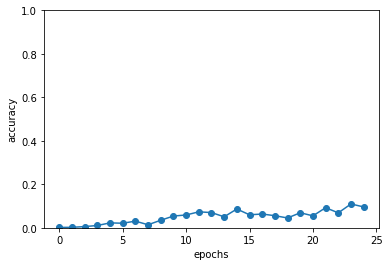

In [14]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()